In [30]:
## Preamble ##

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import gamma

from src.model import Model
from src.model_elo import EloModel

def dr(df):
    with pd.option_context('display.max_rows', None):
        display(df)
        
def dc(df):
    with pd.option_context('display.max_columns', None):
        display(df)
        
def drc(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
dcr = drc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
## Read in data ##

FRIENDLY_LOSS_WEIGHT = 0.5

results_raw = pd.read_csv("match_results/results.csv", parse_dates=["date"])
results = pd.read_csv("match_results/results_clean.csv", parse_dates=["date"])
results["year"] = results["date"].apply(lambda x: x.year)
confederations = pd.read_csv("reference_data/confederations.csv")
first_confederation = confederations.query("start_year.isna()").set_index("team").confederation
all_teams = pd.read_csv("reference_data/team_universe.csv")
current_fifa_members = all_teams.query("category == 'fifa_member'").team.tolist()
other_teams = all_teams.query("category != 'fifa_member'").team.tolist()
current_teams = all_teams.query("category != 'past_team'").team.tolist()

def get_results(team, second_team=None, res=results, start_date=None, end_date = None):
    df_ = res.query(f"home_team == '{team}' or away_team == '{team}'")
    if second_team is not None:
        df_ = df_.query(f"home_team == '{second_team}' or away_team == '{second_team}'")
    if start_date is not None:
        df_ = df_.loc[df_.date >= start_date]
    if end_date is not None:
        df_ = df_.loc[df_.date <= end_date]
    return df_

def calc_loss(res, friendly_loss_weight=FRIENDLY_LOSS_WEIGHT):
    w = np.where(res.tournament == "Friendly", friendly_loss_weight, 1)
    return (
        (res.loss_result * w).sum() / w.sum(),
        (res.loss_score * w).sum() / w.sum()
    )

In [32]:
## Train model ##

model = Model(cross_var_ratio=0.5)
res = model.fit(results.iloc[::])

R = res.query("min_games_played >= 10 and date >= '1980'")
loss_result, loss_score = calc_loss(R)
print(f"Loss result: {loss_result*100:6.2f}")
print(f"Loss score:  {loss_score*100 :6.2f}")

Loss result:  78.67
Loss score:  279.06


In [33]:
from src.tournament import WorldCup2026

T = []
N = 1000
for i in range(N):
    t = WorldCup2026(host_teams=["USA", "Canada", "Mexico"])
    t.simulate(model, random_state=i)
    T.append(t)

champions = pd.Series([t.champion for t in T])

In [34]:
## Export metrics and define qualities ##

df_state = model.export_state_df()
df_mu = model.export_mu_df()
df_hga = model.export_hga_df()
df_state["quality"] = df_state["mu_attack"] + df_state["mu_defense"]
df_state["quality_low"] = df_state["quality"] - 2 * np.sqrt(df_state["sigma_attack"] + df_state["sigma_defense"] + 2 * df_state["sigma_ad"])
df_state["mu_attack_low"] = df_state["mu_attack"] - 2 * np.sqrt(df_state["sigma_attack"])
df_state["mu_defense_low"] = df_state["mu_defense"] - 2 * np.sqrt(df_state["sigma_defense"])
df_state["year"] = df_state.date.apply(lambda x: x.year)

In [35]:
## convert from params to ratings ##

a = 6.0 # larger = more teams get to be high 90s
b = 2.1 # larger = teams drawn away from zero
c = 1.0 # anything above this will be treated identically, so teams should not get near it
cdf_func = lambda x: 1.0 - gamma.cdf(c - x, a=a, scale=b/a)
rating_func = lambda x: 100 * cdf_func(x)
df_state["rating_attack"] = rating_func(df_state["mu_attack"])
df_state["rating_defense"] = rating_func(df_state["mu_defense"])
df_state["rating"] = rating_func(df_state["quality"] / 2)
# df_state.query("year >= 2000")["rating"].round().astype(int).value_counts().sort_index().plot.bar(title="Quality", figsize=(20,5)); plt.show()
# df_state.query("year >= 2000")["rating_attack"].round().astype(int).value_counts().sort_index().plot.bar(title="Attack", color="red", figsize=(20,5)); plt.show()
# df_state.query("year >= 2000")["rating_defense"].round().astype(int).value_counts().sort_index().plot.bar(title="Defense", color="green", figsize=(20,5)); plt.show()

In [36]:
## produce team histories, ratings, and rankings ##

df_history = df_state.set_index(["date", "team"]).unstack().ffill()

for team in all_teams.query("category == 'past_team'").team:
    last_date = get_results(team).date.max().date()
    df_history.loc[
        df_history.index > last_date,
        [c for c in df_history.columns if c[1] == team]
    ] = np.nan

current_rating = df_history.rating[current_teams].iloc[-1].sort_values(ascending=False).round(2)
current_rating.name = "rating"
elo_ratings = pd.read_csv("reference_data/alt_rankings/elo_ratings_20260104.csv")
fifa_ratings = pd.read_csv("reference_data/alt_rankings/fifa_rankings_20251218.csv")

# all_ratings = df_history[["rating", "rating_attack", "rating_defense", "quality", "mu_attack", "mu_defense"]].iloc[-1].unstack().T
all_ratings = df_history.iloc[-1].unstack().T
all_rankings = current_rating.to_frame().reset_index().rename(columns={"rating": "model"})
all_rankings = all_rankings.merge(elo_ratings, on="team")
all_rankings = all_rankings.merge(fifa_ratings[["team", "fifa_points"]].rename(columns={"fifa_points": "fifa"}), on="team")
all_rankings.set_index("team", inplace=True)
C = all_rankings.columns.tolist()
for attr in C:
    all_rankings[f"rank_{attr}"] = (
        all_rankings[attr]
        .rank(method="min", ascending=False, na_option="bottom")
        .astype("Int64")
    )
for attr in C:
    if c == "model":
        continue
    all_rankings[f"rank_diff_{attr}"] = all_rankings["rank_model"] - all_rankings[f"rank_{attr}"]
all_rankings.head(10)

,model,elo,fifa,rank_model,rank_elo,rank_fifa,rank_diff_model,rank_diff_elo,rank_diff_fifa
team,,,,,,,,,
Argentina,97.91,2113,1873.33,1,2,2,0,-1,-1
Spain,97.84,2171,1877.18,2,1,1,0,1,1
Brazil,96.93,1979,1760.46,3,6,5,0,-3,-2
England,96.25,2042,1834.12,4,4,4,0,0,0
Colombia,96.18,1998,1701.30,5,5,13,0,0,-8
Portugal,95.25,1976,1760.38,6,7,6,0,-1,0
France,95.03,2062,1870.00,7,3,3,0,4,4
Netherlands,93.40,1959,1756.27,8,8,7,0,0,1
Germany,91.91,1910,1724.15,9,12,9,0,-3,0


In [37]:
wc_teams = sorted(set(t.results_frame().home_team.tolist() + t.results_frame().away_team.tolist()))

elim = [t.stage_of_elimination() for t in T]
stages = set(elim[0].values())

stages = sorted(set(elim[0].values()))

stage_counts = pd.DataFrame(
    index=wc_teams,
    columns=stages,
    data=0
)
for e in elim:
    for team, stage in e.items():
        stage_counts.loc[team, stage] += 1

In [ ]:
ratings_with_wins = all_ratings.loc[wc_teams].sort_values("quality", ascending=False).join(stage_counts)
dcr(ratings_with_wins.iloc[:,-12:])

## Tuning and validation

In [232]:
def to_team_long(df: pd.DataFrame) -> pd.DataFrame:
    required = {"home_team", "away_team", "home_score", "away_score", "neutral"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"missing required columns: {sorted(missing)}")

    def _rename_side(df_in: pd.DataFrame, team_side: str) -> pd.DataFrame:
        if team_side == "home":
            base_map = {
                "home_team": "team",
                "away_team": "opponent",
                "home_score": "team_score",
                "away_score": "opp_score",
            }
            team_prefix = "home_"
            opp_prefix = "away_"
            home_to_team = True
            neutrality = np.where(df_in["neutral"], "neutral", "home")
        else:
            base_map = {
                "away_team": "team",
                "home_team": "opponent",
                "away_score": "team_score",
                "home_score": "opp_score",
            }
            team_prefix = "away_"
            opp_prefix = "home_"
            home_to_team = False
            neutrality = np.where(df_in["neutral"], "neutral", "away")

        rename = {}
        for col in df_in.columns:
            if col in base_map:
                rename[col] = base_map[col]
                continue
            if col.startswith(team_prefix):
                rename[col] = "team_" + col[len(team_prefix):]
                continue
            if col.startswith(opp_prefix):
                rename[col] = "opp_" + col[len(opp_prefix):]
                continue

            # handle exp_home_score, m_home_pre, p_home, etc.
            new_col = col
            if home_to_team:
                new_col = new_col.replace("_home_", "_team_").replace("_away_", "_opp_")
                if new_col.endswith("_home"):
                    new_col = new_col[:-5] + "_team"
                if new_col.endswith("_away"):
                    new_col = new_col[:-5] + "_opp"
            else:
                new_col = new_col.replace("_home_", "_opp_").replace("_away_", "_team_")
                if new_col.endswith("_home"):
                    new_col = new_col[:-5] + "_opp"
                if new_col.endswith("_away"):
                    new_col = new_col[:-5] + "_team"

            if new_col != col:
                rename[col] = new_col

        out = df_in.rename(columns=rename).copy()
        out["neutrality"] = neutrality

        if {"p_home", "p_draw", "p_away"} <= set(out.columns):
            if team_side == "home":
                out["p_win"] = out["p_home"]
                out["p_draw"] = out["p_draw"]
                out["p_loss"] = out["p_away"]
            else:
                out["p_win"] = out["p_away"]
                out["p_draw"] = out["p_draw"]
                out["p_loss"] = out["p_home"]

        if {"odds_home", "odds_draw", "odds_away"} <= set(out.columns):
            if team_side == "home":
                out["odds_win"] = out["odds_home"]
                out["odds_draw"] = out["odds_draw"]
                out["odds_loss"] = out["odds_away"]
            else:
                out["odds_win"] = out["odds_away"]
                out["odds_draw"] = out["odds_draw"]
                out["odds_loss"] = out["odds_home"]

        out = out.drop(columns=["neutral"])
        return out

    home_df = _rename_side(df, "home")
    away_df = _rename_side(df, "away")
    home_df["idx"] = range(len(home_df))
    away_df["idx"] = range(len(away_df))
    return pd.concat([home_df, away_df], ignore_index=True).sort_values("idx").reset_index(drop=True).drop(columns=["idx"])

In [248]:
res_long = to_team_long(res)
res_long["exp_points"] = res_long.p_team + 0.5 * res_long.p_draw
res_long["points"] = 0
res_long["points"] = np.where(res_long.team_score > res_long.opp_score, 1, res_long.points)
res_long["points"] = np.where(res_long.team_score == res_long.opp_score, 0.5, res_long.points)
res_long["team_outperformance_attack"] = res_long["team_score"] - res_long["exp_team_score"]
res_long["team_outperformance_defense"] = -1 * (res_long["opp_score"] - res_long["exp_opp_score"])
res_long["team_outperformance_net"] = res_long["team_outperformance_attack"] + res_long["team_outperformance_defense"]
res_long["team_outperformance_points"] = res_long["points"] - res_long["exp_points"]

In [285]:
res_long.query("date > '2010'").groupby("team")[["points", "exp_points"]].sum().eval("outperformance=points-exp_points").sort_values("outperformance")

,points,exp_points,outperformance
team,,,
Latvia,53.0,65.908969,-12.908969
Lithuania,41.5,51.232454,-9.732454
Barbados,31.0,40.055157,-9.055157
Maldives,44.5,53.541139,-9.041139
Cyprus,38.5,47.459009,-8.959009
...,...,...,...
Panama,116.5,106.973720,9.526280
Argentina,159.5,149.051906,10.448094
Kosovo,50.5,39.355524,11.144476


In [275]:
res_long.query("date > '2010'").groupby("team")["team_outperformance_net"].sum().sort_values()

team
Singapore            -58.370598
Barbados             -54.099727
Bulgaria             -49.329375
Myanmar              -46.101665
Seychelles           -45.473290
                        ...    
Dominican Republic    55.808309
Philippines           63.266881
Comoros               63.701179
Kosovo                68.363341
Guam                  77.719664
Name: team_outperformance_net, Length: 217, dtype: float64

<Axes: xlabel='date'>

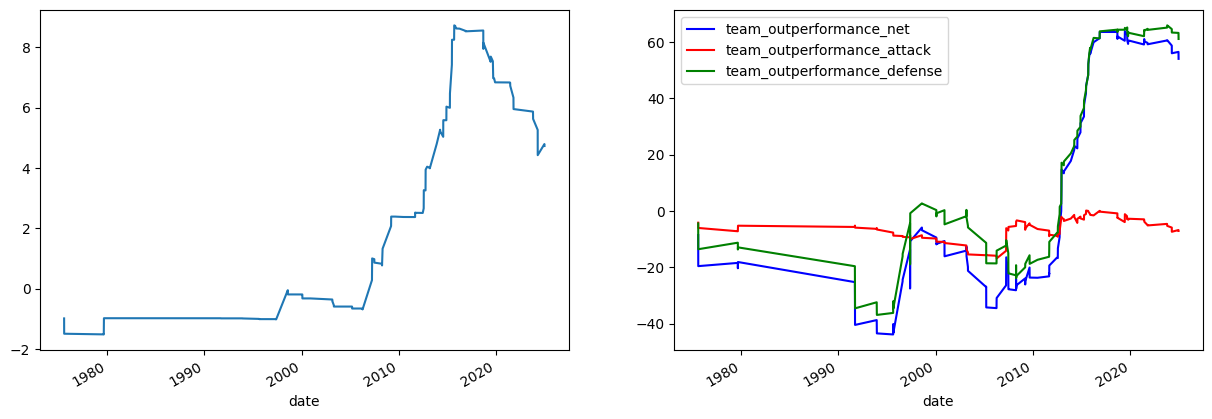

In [278]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
top20_teams = all_rankings.iloc[:20].index.tolist()
T = ["Guam"]
res_long.loc[res_long.team.isin(T)].set_index("date").team_outperformance_points.cumsum().plot(ax=axs[0])
res_long.loc[res_long.team.isin(T)].set_index("date")[["team_outperformance_net", "team_outperformance_attack", "team_outperformance_defense"]].cumsum().plot(ax=axs[1], color=["blue", "red", "green"])

<Axes: >

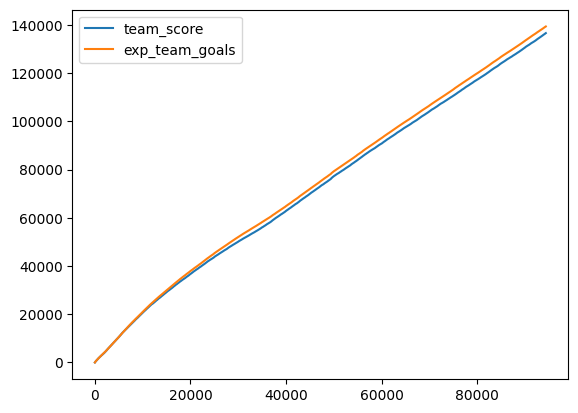

In [177]:
res_long[["team_score", "exp_team_score"]].cumsum().plot()

All eval'd over 1980-, min_games=10, friendly loss weight applies

| Link    | Result loss | Score loss |
| ------: | ----------: | ---------: |
| `rho=0.05` | 79.6 | 281.2 |
| `rho=0.10` | 79.4 | 281.1 |
| `rho=0.15` | 79.33 | 281.20 |
| `rho=0.20` | 79.25 | 281.40 |
| `rho=0.25` | 79.2 | 281.4 |
| `rho=0.30` | 79.2 | 282.2 |

Fixing `rho=0.15`...

| Link    | Result loss | Score loss |
| ------: | ----------: | ---------: |
| `var_per_year_bps=5` | 80.48 | 284.44 |
| `var_per_year_bps=20` | 79.33 | 281.20 |
| `var_per_year_bps=40` | 78.99 | 280.22 |
| `var_per_year_bps=50` | 78.92 | 280.04 |
| `var_per_year_bps=100` | 78.86 | 279.89 |
| `var_per_year_bps=500` | 79.72 | 282.62 |

Fixing `var_per_year_bps=40` because larger meant worse calibration plots. Tried but decided against var caps...

Fixing `mu_prior_decay_bps=100` with a cumulative expected / actual goals in early games plot.

Now looking at games with `min_games_played <= 5` to optimise that initial variance...

| Link    | Result loss | Score loss |
| ------: | ----------: | ---------: |
| `init_var_diag=500` | 83.44 | 398.57 |
| `init_var_diag=2000` | 80.70 | 389.89 |
| `init_var_diag=5000` | 81.55 | 393.44 |

Now looking at HGA (back to at least 10 games from 1980 onwards)... for all of these, we set the init var to be 10 years worth...

| Link    | Result loss | Score loss |
| ------: | ----------: | ---------: |
| `hga_rw_var_per_year_bps=0.01` | 79.16 | 279.96 |
| `hga_rw_var_per_year_bps=0.1` | 79.11 | 279.94 |
| `hga_rw_var_per_year_bps=1.0` | 79.12 | 280.09 |
| `hga_rw_var_per_year_bps=10.0` | 79.17 | 280.19 |

In [ ]:
## Calibration: are we predicting results well? ##
def calibration_results(res, display="cumsum"):
    res = res.copy()
    res["result_is_home"]  = res.home_score > res.away_score
    res["result_is_away"]  = res.away_score > res.home_score
    res["result_is_draw"]  = res.home_score == res.away_score
    res["result_is_not_draw"] = res.home_score != res.away_score
    res["total_score"]     = res.home_score + res.away_score
    res["exp_total_score"] = res.exp_home_score + res.exp_away_score
    res["p_not_draw"]      = 1 - res["p_draw"]
    res = res.set_index("date")
    fix, axs = plt.subplots(4, 2, figsize=(8,12))
    if display == "cumsum":
        f = lambda x: x.cumsum()
    elif display == "rolling":
        f = lambda x: x.rolling(2000).mean()
    for i, outcome in enumerate(("home", "away", "draw")):
        f(res.query("~neutral")[[f"result_is_{outcome}", f"p_{outcome}"]]).plot(ax=axs[i][0], title=f"Non-neutral {outcome}")
        if outcome == "draw":
            f(res.query("~neutral")[["total_score", "exp_total_score"]]).plot(ax=axs[i][1], title="Non-neutral combined")
        else:
            f(res.query("~neutral")[[f"{outcome}_score", f"exp_{outcome}_score"]]).plot(ax=axs[i][1], title=f"Non-neutral {outcome}")
    f(res.query("neutral")[["result_is_not_draw", "p_not_draw"]]).plot(ax=axs[3][0], title="Neutral")
    f(res.query("neutral and result_is_not_draw")[["total_score", "exp_total_score"]]).plot(ax=axs[3][1], title="Neutral")
    
    plt.tight_layout()
    plt.show()

calibration_results(res, display="rolling")

Mean result loss =   81.2
Mean score loss  =  277.8


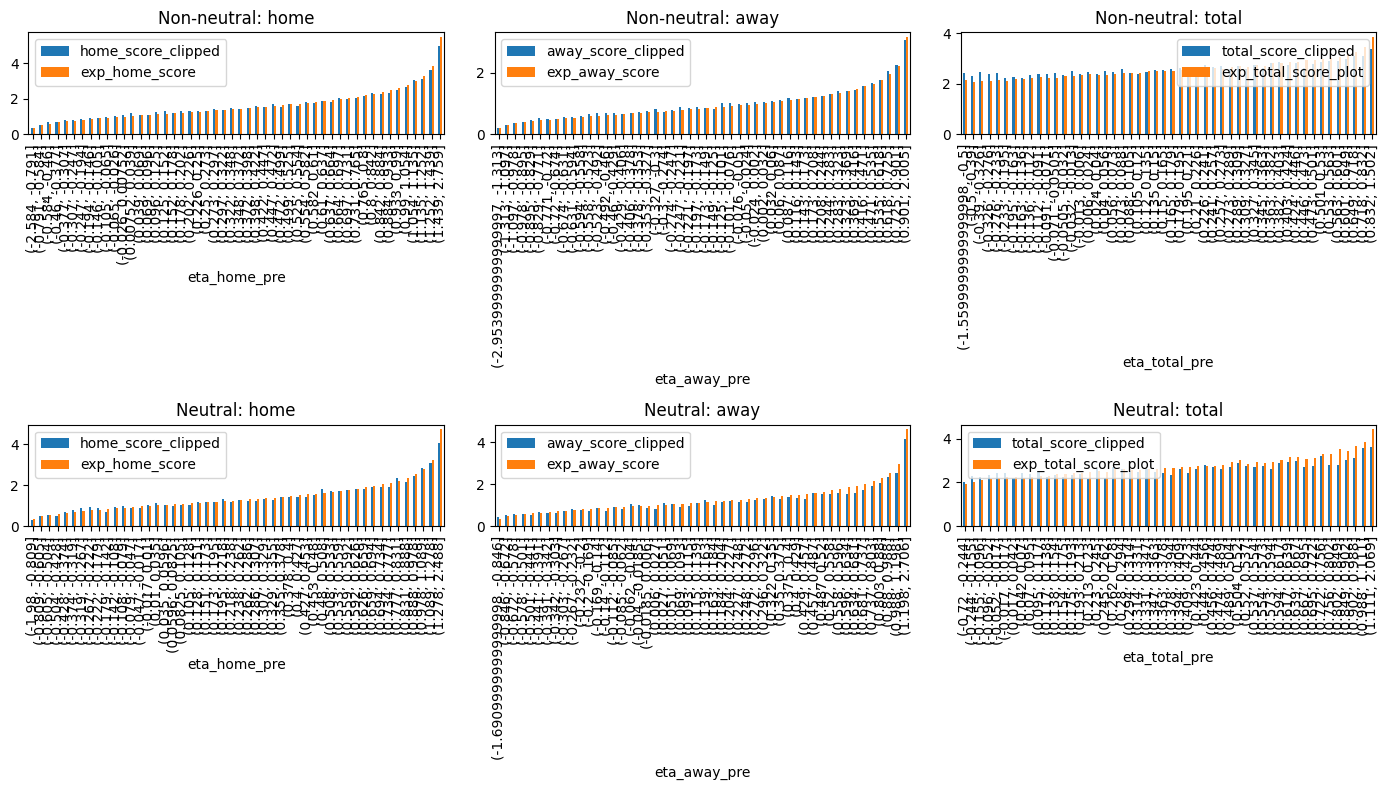

log mean abs error (home/away): -2.814 -3.126


In [174]:
## Calibration: is the link set well? ##

START_YEAR = 1980  # set to int year if you want a subset
END_YEAR = None    # set to int year if you want a subset

def calibration_plots(res, start_year=None, end_year=None, q=20, min_games=10, mode="means", use_corr=False, var_eta_max=None):
    R = res.copy()
    if start_year is not None or end_year is not None:
        years = R["date"].dt.year
        fil = np.repeat(True, len(R))
        if start_year is not None:
            fil = fil & (years >= start_year)
        if end_year is not None:
            fil = fil & (years <= end_year)
        R = R.loc[fil]
    if min_games is not None:
        R = R[(R["home_games_played"] >= min_games) & (R["away_games_played"] >= min_games)]
    print(f"Mean result loss = {R.loss_result.mean()*100 :6.1f}")
    print(f"Mean score loss  = {R.loss_score.mean()*100 :6.1f}")

    needed_eta = {"eta_home_pre", "eta_away_pre"}
    missing_eta = needed_eta.difference(R.columns)
    if missing_eta:
        raise ValueError(f"calibration_plots requires columns: {sorted(missing_eta)}")
    R["eta_total_pre"] = R["eta_home_pre"] + R["eta_away_pre"]


    R["total_score"] = R["home_score"] + R["away_score"]
    R["exp_total_score"] = R["exp_home_score"] + R["exp_away_score"]

    R["home_score_clipped"] = R["home_score"].clip(0, float("inf"))
    R["away_score_clipped"] = R["away_score"].clip(0, float("inf"))
    R["total_score_clipped"] = R["home_score_clipped"] + R["away_score_clipped"]

    if use_corr or var_eta_max is not None:
        needed = {"f_home_pre", "f_away_pre", "fprime_home_pre", "fprime_away_pre",
                  "home_sigma_attack_pre", "home_sigma_defense_pre",
                  "away_sigma_attack_pre", "away_sigma_defense_pre"}
        missing = needed.difference(R.columns)
        if missing:
            raise ValueError(f"use_corr/var_eta_max requires columns: {sorted(missing)}")
        R["var_eta_home"] = R["home_sigma_attack_pre"] + R["away_sigma_defense_pre"]
        R["var_eta_away"] = R["away_sigma_attack_pre"] + R["home_sigma_defense_pre"]
        if var_eta_max is not None:
            R = R[(R["var_eta_home"] <= var_eta_max) & (R["var_eta_away"] <= var_eta_max)]

    if use_corr:
        R["exp_home_score_corr"] = np.exp(
            R["f_home_pre"] + 0.5 * (R["fprime_home_pre"] ** 2) * R["var_eta_home"]
        )
        R["exp_away_score_corr"] = np.exp(
            R["f_away_pre"] + 0.5 * (R["fprime_away_pre"] ** 2) * R["var_eta_away"]
        )

    exp_home_col = "exp_home_score_corr" if use_corr else "exp_home_score"
    exp_away_col = "exp_away_score_corr" if use_corr else "exp_away_score"
    R["exp_total_score_plot"] = R[exp_home_col] + R[exp_away_col]
    exp_total_col = "exp_total_score_plot"

    def _binned_stats_by_eta(df, eta_col, exp_col, actual_col):
        bins = pd.qcut(df[eta_col].round(3), q=q, duplicates="drop")
        stats = df.groupby(bins, observed=False)[[actual_col, exp_col, eta_col]].mean()
        stats["resid"] = stats[actual_col] - stats[exp_col]
        stats["eta_mean"] = stats[eta_col]
        return stats

    fig, axs = plt.subplots(2, 3, figsize=(14, 8))

    non = R.query("~neutral")
    neu = R.query("neutral")

    stats_non_home = _binned_stats_by_eta(non, "eta_home_pre", exp_home_col, "home_score_clipped")
    stats_non_away = _binned_stats_by_eta(non, "eta_away_pre", exp_away_col, "away_score_clipped")
    stats_non_total = _binned_stats_by_eta(non, "eta_total_pre", exp_total_col, "total_score_clipped")

    stats_neu_home = _binned_stats_by_eta(neu, "eta_home_pre", exp_home_col, "home_score_clipped")
    stats_neu_away = _binned_stats_by_eta(neu, "eta_away_pre", exp_away_col, "away_score_clipped")
    stats_neu_total = _binned_stats_by_eta(neu, "eta_total_pre", exp_total_col, "total_score_clipped")

    if mode == "resid":
        axs[0, 0].plot(stats_non_home["eta_mean"], stats_non_home["resid"], marker="o")
        axs[0, 0].axhline(0.0, color="black", linewidth=1)
        axs[0, 0].set_title("Non-neutral: home")
        axs[0, 0].set_xlabel("mean eta")
        axs[0, 0].set_ylabel("mean residual (actual - expected)")

        axs[0, 1].plot(stats_non_away["eta_mean"], stats_non_away["resid"], marker="o")
        axs[0, 1].axhline(0.0, color="black", linewidth=1)
        axs[0, 1].set_title("Non-neutral: away")
        axs[0, 1].set_xlabel("mean eta")
        axs[0, 1].set_ylabel("mean residual (actual - expected)")

        axs[0, 2].plot(stats_non_total["eta_mean"], stats_non_total["resid"], marker="o")
        axs[0, 2].axhline(0.0, color="black", linewidth=1)
        axs[0, 2].set_title("Non-neutral: total")
        axs[0, 2].set_xlabel("mean eta (home+away)")
        axs[0, 2].set_ylabel("mean residual (actual - expected)")

        axs[1, 0].plot(stats_neu_home["eta_mean"], stats_neu_home["resid"], marker="o")
        axs[1, 0].axhline(0.0, color="black", linewidth=1)
        axs[1, 0].set_title("Neutral: home")
        axs[1, 0].set_xlabel("mean eta")
        axs[1, 0].set_ylabel("mean residual (actual - expected)")

        axs[1, 1].plot(stats_neu_away["eta_mean"], stats_neu_away["resid"], marker="o")
        axs[1, 1].axhline(0.0, color="black", linewidth=1)
        axs[1, 1].set_title("Neutral: away")
        axs[1, 1].set_xlabel("mean eta")
        axs[1, 1].set_ylabel("mean residual (actual - expected)")

        axs[1, 2].plot(stats_neu_total["eta_mean"], stats_neu_total["resid"], marker="o")
        axs[1, 2].axhline(0.0, color="black", linewidth=1)
        axs[1, 2].set_title("Neutral: total")
        axs[1, 2].set_xlabel("mean eta (home+away)")
        axs[1, 2].set_ylabel("mean residual (actual - expected)")
    else:
        stats_non_home[["home_score_clipped", exp_home_col]].plot.bar(ax=axs[0, 0], title="Non-neutral: home")
        stats_non_away[["away_score_clipped", exp_away_col]].plot.bar(ax=axs[0, 1], title="Non-neutral: away")
        stats_non_total[["total_score_clipped", exp_total_col]].plot.bar(ax=axs[0, 2], title="Non-neutral: total")

        stats_neu_home[["home_score_clipped", exp_home_col]].plot.bar(ax=axs[1, 0], title="Neutral: home")
        stats_neu_away[["away_score_clipped", exp_away_col]].plot.bar(ax=axs[1, 1], title="Neutral: away")
        stats_neu_total[["total_score_clipped", exp_total_col]].plot.bar(ax=axs[1, 2], title="Neutral: total")

    plt.tight_layout()
    plt.show()

    home_score = (
        _binned_stats_by_eta(R, "eta_home_pre", exp_home_col, "home_score_clipped")
        .eval("L = abs(home_score_clipped - {col})".format(col=exp_home_col))
        .L.mean()
    )
    away_score = (
        _binned_stats_by_eta(R, "eta_away_pre", exp_away_col, "away_score_clipped")
        .eval("L = abs(away_score_clipped - {col})".format(col=exp_away_col))
        .L.mean()
    )
    print("log mean abs error (home/away):", round(np.log(home_score), 3), round(np.log(away_score), 3))

calibration_plots(res, START_YEAR, END_YEAR, q=50, min_games=50, mode="resida", use_corr=False, var_eta_max=None)

In [1055]:
# score matrix diagnostics: empirical vs expected counts
from src.model import MAX_GOALS, log_factorial

score_mode = "home_away"


def score_matrices(res_in, max_goals=MAX_GOALS, mode="home_away"):
    if mode not in ("home_away", "winner"):
        raise ValueError("mode must be 'home_away' or 'winner'")
    log_fact = np.array([log_factorial(i) for i in range(max_goals + 1)], dtype=float)

    def poisson_pmf(lam):
        if lam <= 0.0:
            pmf = np.zeros(max_goals + 1, dtype=float)
            pmf[0] = 1.0
            return pmf
        k = np.arange(max_goals + 1, dtype=float)
        log_p = -lam + k * np.log(lam) - log_fact
        return np.exp(log_p)

    def score_prob_matrix(lam_h, lam_a, nu):
        p_x = poisson_pmf(lam_h)
        p_y = poisson_pmf(lam_a)
        if nu < 1e-14:
            joint = np.outer(p_x, p_y)
        else:
            p_u = poisson_pmf(nu)
            joint = np.zeros((max_goals + 1, max_goals + 1), dtype=float)
            for u in range(max_goals + 1):
                if p_u[u] == 0.0:
                    continue
                px = p_x[: max_goals + 1 - u]
                py = p_y[: max_goals + 1 - u]
                joint[u:, u:] += p_u[u] * np.outer(px, py)
        total = float(joint.sum())
        if total > 0.0:
            joint = joint / total
        return joint

    def transform_joint(joint):
        if mode == "home_away":
            return joint
        out = np.zeros_like(joint)
        for i in range(max_goals + 1):
            for j in range(max_goals + 1):
                w = i if i >= j else j
                l = j if i >= j else i
                out[w, l] += joint[i, j]
        return out

    emp_counts = np.zeros((max_goals + 1, max_goals + 1), dtype=int)
    exp_counts = np.zeros((max_goals + 1, max_goals + 1), dtype=float)

    for row in res_in.itertuples():
        h = min(int(row.home_score), max_goals)
        a = min(int(row.away_score), max_goals)
        if mode == "winner" and a > h:
            h, a = a, h
        emp_counts[h, a] += 1
        joint = score_prob_matrix(float(row.lam_home_pre), float(row.lam_away_pre), float(row.nu_pre))
        exp_counts += transform_joint(joint)

    labels = list(range(max_goals + 1))
    emp_counts_df = pd.DataFrame(emp_counts, index=labels, columns=labels)
    exp_counts_df = pd.DataFrame(exp_counts, index=labels, columns=labels)
    return emp_counts_df, exp_counts_df


# example: full dataset (pass any subset of res instead)
emp_counts_df, exp_counts_df = score_matrices(R, mode=score_mode)

n = int(emp_counts_df.values.sum())
display((emp_counts_df / n * 100).round(2))
display((exp_counts_df / n * 100).round(2))
display(((emp_counts_df - exp_counts_df) / n * 100).round(2))
# resids = (emp_counts_df - exp_counts_df).astype(int)
# display(resids)

,0,1,2,3,4,5,6,7,8,9,10
0,9.27,7.62,4.85,2.29,1.11,0.45,0.28,0.17,0.07,0.01,0.08
1,11.50,10.69,5.19,1.95,0.77,0.26,0.11,0.08,0.03,0.01,0.01
2,8.49,7.69,3.75,1.39,0.40,0.12,0.05,0.02,0.01,0.00,0.00
3,4.94,3.51,1.69,0.50,0.15,0.03,0.01,0.00,0.00,0.00,0.00
4,2.67,1.69,0.67,0.23,0.05,0.01,0.00,0.00,0.00,0.00,0.00
5,1.46,0.72,0.22,0.08,0.02,0.01,0.00,0.00,0.00,0.00,0.00
6,0.76,0.36,0.10,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.42,0.13,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.24,0.08,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.13,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10
0,9.50,8.49,4.77,2.26,1.02,0.47,0.22,0.12,0.06,0.04,0.03
1,11.38,9.73,5.10,2.18,0.86,0.33,0.14,0.06,0.03,0.02,0.01
2,8.40,6.73,3.33,1.32,0.47,0.16,0.06,0.02,0.01,0.00,0.00
3,5.05,3.70,1.71,0.64,0.21,0.07,0.02,0.01,0.00,0.00,0.00
4,2.76,1.81,0.77,0.27,0.09,0.03,0.01,0.00,0.00,0.00,0.00
5,1.46,0.84,0.32,0.11,0.03,0.01,0.00,0.00,0.00,0.00,0.00
6,0.77,0.39,0.13,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.00
7,0.43,0.18,0.06,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.25,0.09,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.15,0.05,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10
0,-0.23,-0.87,0.09,0.03,0.09,-0.01,0.06,0.06,0.0,-0.03,0.05
1,0.12,0.96,0.09,-0.23,-0.09,-0.07,-0.03,0.03,0.0,-0.00,0.00
2,0.09,0.96,0.42,0.06,-0.08,-0.04,-0.01,-0.00,-0.0,-0.00,-0.00
3,-0.10,-0.19,-0.02,-0.14,-0.07,-0.03,-0.01,-0.00,-0.0,-0.00,-0.00
4,-0.09,-0.13,-0.10,-0.04,-0.04,-0.01,-0.01,-0.00,-0.0,-0.00,-0.00
5,0.01,-0.13,-0.10,-0.03,-0.01,-0.00,-0.00,-0.00,-0.0,-0.00,-0.00
6,-0.01,-0.03,-0.03,-0.03,-0.01,-0.00,-0.00,-0.00,-0.0,-0.00,-0.00
7,-0.01,-0.05,-0.04,-0.01,-0.00,-0.00,-0.00,-0.00,-0.0,-0.00,-0.00
8,-0.00,-0.01,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.0,-0.00,-0.00
9,-0.03,-0.01,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.0,-0.00,-0.00


In [1054]:
# bootstrap p-value + cell diagnostics
def score_matrix_bootstrap_gof(res_in, max_goals=MAX_GOALS, n_boot=200, min_expected=1.0, seed=0, mode="home_away"):
    if mode not in ("home_away", "winner"):
        raise ValueError("mode must be 'home_away' or 'winner'")
    rng = np.random.default_rng(seed)
    log_fact = np.array([log_factorial(i) for i in range(max_goals + 1)], dtype=float)

    def poisson_pmf(lam):
        if lam <= 0.0:
            pmf = np.zeros(max_goals + 1, dtype=float)
            pmf[0] = 1.0
            return pmf
        k = np.arange(max_goals + 1, dtype=float)
        log_p = -lam + k * np.log(lam) - log_fact
        return np.exp(log_p)

    def score_prob_matrix(lam_h, lam_a, nu):
        p_x = poisson_pmf(lam_h)
        p_y = poisson_pmf(lam_a)
        if nu < 1e-14:
            joint = np.outer(p_x, p_y)
        else:
            p_u = poisson_pmf(nu)
            joint = np.zeros((max_goals + 1, max_goals + 1), dtype=float)
            for u in range(max_goals + 1):
                if p_u[u] == 0.0:
                    continue
                px = p_x[: max_goals + 1 - u]
                py = p_y[: max_goals + 1 - u]
                joint[u:, u:] += p_u[u] * np.outer(px, py)
        total = float(joint.sum())
        if total > 0.0:
            joint = joint / total
        return joint

    def transform_joint(joint):
        if mode == "home_away":
            return joint
        out = np.zeros_like(joint)
        for i in range(max_goals + 1):
            for j in range(max_goals + 1):
                w = i if i >= j else j
                l = j if i >= j else i
                out[w, l] += joint[i, j]
        return out

    def gof_stats(emp, exp):
        mask = exp >= min_expected
        emp_use = emp[mask]
        exp_use = exp[mask]
        chi2 = float(np.sum((emp_use - exp_use) ** 2 / exp_use))
        g2 = float(2.0 * np.sum(emp_use * np.log(np.maximum(emp_use, 1e-12) / exp_use)))
        return chi2, g2, int(mask.sum())

    joints = []
    emp_counts = np.zeros((max_goals + 1, max_goals + 1), dtype=int)
    for row in res_in.itertuples():
        h = min(int(row.home_score), max_goals)
        a = min(int(row.away_score), max_goals)
        if mode == "winner" and a > h:
            h, a = a, h
        emp_counts[h, a] += 1
        joint = score_prob_matrix(float(row.lam_home_pre), float(row.lam_away_pre), float(row.nu_pre))
        joints.append(transform_joint(joint))

    exp_counts = np.sum(joints, axis=0)
    chi2_obs, g2_obs, n_cells = gof_stats(emp_counts.astype(float), exp_counts)

    g2_boot = np.zeros(n_boot, dtype=float)
    chi2_boot = np.zeros(n_boot, dtype=float)
    flat_size = (max_goals + 1) * (max_goals + 1)
    for b in range(n_boot):
        emp_b = np.zeros_like(emp_counts, dtype=float)
        for joint in joints:
            flat = joint.ravel()
            idx = int(rng.choice(flat_size, p=flat))
            h = idx // (max_goals + 1)
            a = idx % (max_goals + 1)
            emp_b[h, a] += 1.0
        chi2_b, g2_b, _ = gof_stats(emp_b, exp_counts)
        chi2_boot[b] = chi2_b
        g2_boot[b] = g2_b

    p_g2 = (np.sum(g2_boot >= g2_obs) + 1.0) / (n_boot + 1.0)
    p_chi2 = (np.sum(chi2_boot >= chi2_obs) + 1.0) / (n_boot + 1.0)

    return {
        'chi2_obs': chi2_obs,
        'g2_obs': g2_obs,
        'p_chi2': p_chi2,
        'p_g2': p_g2,
        'n_cells_used': n_cells,
    }

def score_matrix_cell_diagnostics(emp_counts_df, exp_counts_df, min_expected=1.0, z_thresh=3.0, top_n=10):
    emp = emp_counts_df.values.astype(float)
    exp = exp_counts_df.values.astype(float)
    resid = (emp - exp) / np.sqrt(np.maximum(exp, 1e-12))
    ratio = emp / np.maximum(exp, 1e-12)

    rows = []
    for i in range(emp.shape[0]):
        for j in range(emp.shape[1]):
            if exp[i, j] < min_expected:
                continue
            rows.append({
                'row_goals': int(emp_counts_df.index[i]),
                'col_goals': int(emp_counts_df.columns[j]),
                'emp': float(emp[i, j]),
                'exp': float(exp[i, j]),
                'excess': float(emp[i, j] - exp[i, j]),
                'ratio': float(ratio[i, j]),
                'resid': float(resid[i, j]),
            })

    diag = pd.DataFrame(rows).sort_values('resid', ascending=False)
    too_high = diag[diag['resid'] >= z_thresh]

    print(f'too-high cells (resid >= {z_thresh})')
    display(too_high.head(top_n))
    print('top residuals')
    display(diag.head(top_n))
    return diag

score_mode = globals().get('score_mode', 'home_away')
# bootstrap p-values (slow-ish if n_boot is large)
boot = score_matrix_bootstrap_gof(R, n_boot=200, min_expected=1.0, seed=1, mode=score_mode)
print('chi2_obs', round(boot['chi2_obs'], 2), 'p_chi2', round(boot['p_chi2'], 4))
print('g2_obs', round(boot['g2_obs'], 2), 'p_g2', round(boot['p_g2'], 4))

# cell diagnostics for too outperformant scores
diag = score_matrix_cell_diagnostics(emp_counts_df, exp_counts_df, min_expected=1.0, z_thresh=3.0, top_n=15)

chi2_obs 315.57 p_chi2 0.005
g2_obs 320.65 p_g2 0.005
too-high cells (resid >= 3.0)


,row_goals,col_goals,emp,exp,excess,ratio,resid
40,10,0,106.0,45.933565,60.066435,2.307681,8.862715
2,1,1,3680.0,3350.267690,329.732310,1.098420,5.696679
4,2,1,4437.0,4074.290817,362.709183,1.089024,5.682410
5,2,2,1291.0,1145.067091,145.932909,1.127445,4.312586


top residuals


,row_goals,col_goals,emp,exp,excess,ratio,resid
40,10,0,106.0,45.933565,60.066435,2.307681,8.862715
2,1,1,3680.0,3350.267690,329.732310,1.098420,5.696679
4,2,1,4437.0,4074.290817,362.709183,1.089024,5.682410
5,2,2,1291.0,1145.067091,145.932909,1.127445,4.312586
41,10,1,18.0,12.862542,5.137458,1.399412,1.432468
27,7,0,203.0,186.400731,16.599269,1.089052,1.215808
3,2,0,4596.0,4533.746710,62.253290,1.013731,0.924557
21,6,0,360.0,343.999617,16.000383,1.046513,0.862683
8,3,2,1059.0,1044.298938,14.701062,1.014077,0.454921
38,9,2,6.0,5.218715,0.781285,1.149708,0.342001


In [ ]:
R_int = res.query("home_confederation != away_confederation").copy()
R_int["home_pts"] = np.where(R_int.home_score > R_int.away_score, 1, np.where(R_int.home_score == R_int.away_score, 0.5, 0))
R_int["away_pts"] = np.where(R_int.home_score > R_int.away_score, 0, np.where(R_int.home_score == R_int.away_score, 0.5, 1))
R_int["exp_home_pts"] = R_int.p_home + 0.5 * R_int.p_draw
R_int["exp_away_pts"] = R_int.p_away + 0.5 * R_int.p_draw
confs = R_int.home_confederation.unique().tolist()
confs.remove("NO_CONFEDERATION")
k = len(confs)
fig, axs = plt.subplots(k, 3, figsize=(12,20))
for i, conf in enumerate(confs):
    r = pd.concat([
        (R_int.query(f"home_confederation == '{conf}'")
            .eval("score_for = home_score")
            .eval("exp_score_for = exp_home_score")
            .eval("score_against = away_score")
            .eval("exp_score_against = exp_away_score")
            .eval("pts_for = home_pts")
            .eval("exp_pts_for = exp_home_pts")
        ),
        (R_int.query(f"away_confederation == '{conf}'")
            .eval("score_for = away_score")
            .eval("exp_score_for = exp_away_score")
            .eval("score_against = home_score")
            .eval("exp_score_against = exp_home_score")
            .eval("pts_for = away_pts")
            .eval("exp_pts_for = exp_away_pts")
        )
    ]).sort_values("date")
    f = lambda x: x.rolling(500).mean()
    f(r.set_index("date")[["pts_for", "exp_pts_for"]]).plot(ax=axs[i,0], title=f"{conf} points")
    f(r.set_index("date")[["score_for", "exp_score_for"]]).plot(ax=axs[i,1], title=f"{conf} score for")
    f(r.set_index("date")[["score_against", "exp_score_against"]]).plot(ax=axs[i,2], title=f"{conf} score against")
plt.tight_layout()
plt.show()